In [ ]:
%%capture
!pip install ultralytics
import torch
import torchvision
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())
import sys
!{sys.executable} -m pip install opencv-python matplotlib
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/sam2.git'

In [ ]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from skimage.morphology import disk
from skimage.feature import peak_local_max
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
 device = torch.device("cuda")

In [ ]:
np.random.seed(3)

def show_mask(mask, ax, random_color=True, borders = True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        import cv2
        contours, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        # Try to smooth contours
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=30):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

def show_masks(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=True):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        show_mask(mask, plt.gca(), borders=borders)
        if point_coords is not None:
            assert input_labels is not None
            show_points(point_coords, input_labels, plt.gca())
        if box_coords is not None:
            # boxes
            show_box(box_coords, plt.gca())
        if len(scores) > 1:
            plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.show()

In [ ]:
np.random.seed(3)

def show_anns(anns, borders=True):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:, :, 3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.5]])
        img[m] = color_mask
        if borders:
            import cv2
            contours, _ = cv2.findContours(m.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
            # Try to smooth contours
            contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
            cv2.drawContours(img, contours, -1, (0, 0, 1, 0.4), thickness=1)

    ax.imshow(img)

In [ ]:
plt.rcParams['figure.figsize'] = [10, 10]

In [ ]:
iname = "/content/drive/MyDrive/Box_leaf/images/val/1.X5.1.883.jpg"

In [ ]:
image = cv2.imread(iname)

In [ ]:
image.shape

(4032, 2268, 3)

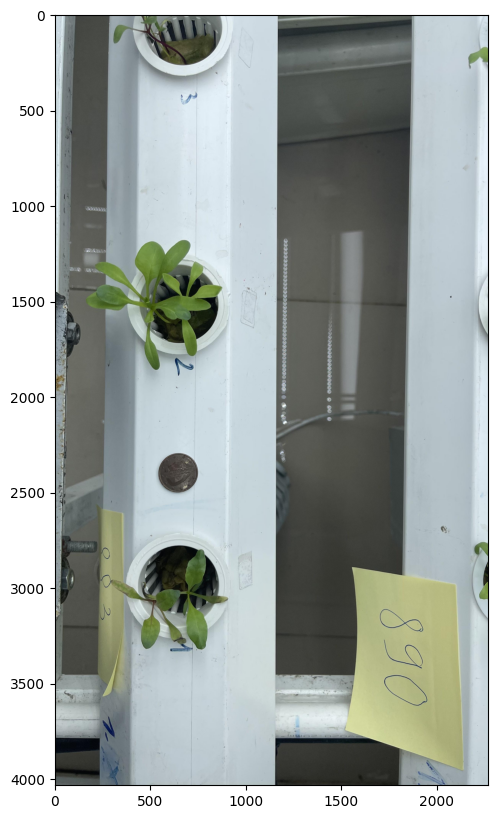

In [ ]:
plt.imshow(image[:,:,::-1])
plt.show()

In [ ]:
def check_green(image,min_green = np.array([35,50,50]),max_green = np.array([70,255,255])) :
    # Chuyển ảnh sang HSV
    hsv = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)

    # Tạo mask từ ngưỡng
    mask = cv2.inRange(hsv, min_green, max_green)

    # Xóa nhiễu và làm mịn
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, np.ones((5,5), np.uint8))
    return mask

In [ ]:
def find_leaf_points(mask,min_area = 300):
    points = []
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
    erosion = cv2.erode(mask,kernel,iterations=1)
    plt.imshow(erosion)
    plt.show()
    # Tìm từng vùng connected component
    num_labels, labels,stats,centroids = cv2.connectedComponentsWithStats(erosion, connectivity=8)
    for i in range(1,num_labels) :
        _,_,_,_,area = stats[i]
        if area < min_area:
            erosion[labels == i] = 0
        if area > min_area and area < 10000 :
            points.append(centroids[i])
            erosion[labels == i] = 0

    dist = cv2.distanceTransform(erosion, cv2.DIST_L2, 5)
    dist = cv2.GaussianBlur(dist, (11,11), 0)
    plt.imshow(dist)
    plt.show()
    coords = peak_local_max(dist, min_distance=30,threshold_abs=10)
    coords = np.array([(int(x), int(y)) for (y, x) in coords])
    for i in coords :
        points.append(i)
    return np.array(points)

In [ ]:
def find_crop(image,results) :
    boxes = results[0].boxes.xyxy

    box_results = []
    crops = []
    positions = []
    for i, box in enumerate(boxes):
        x1, y1, x2, y2 = box
        box_results.append(box)

    for i in box_results :
        x1,y1,x2,y2 = i.int().tolist()
        crop = image[y1:y2, x1:x2].copy()
        crops.append(crop)
        positions.append((y1,y2,x1,x2))
    return crops,positions

In [ ]:
def mask_full(mask,h,w,position) :
    mask_f = np.zeros((h, w), dtype=np.uint8)
    y1, y2, x1, x2 = position
    mask_f[y1:y2, x1:x2] = mask
    return mask_f

In [ ]:
def sam2_inputs(points, min_dist=100):
    if len(points) == 0: return []
    if len(points) == 1:
        return np.array([points[0]]),np.array([1])

    points = np.array(points)
    num_points = len(points)
    input_coords = []
    input_labels = []
    for i in range(num_points):
        point = points[i]

        min_d_point = None
        min_d = float('inf')

        for j in range(num_points):
            if i == j: continue

            dist = np.linalg.norm(point - points[j])

            if dist < min_d:
                min_d = dist
                min_d_point = points[j]

        if min_d_point is not None:
            if min_d > min_dist:
                input_coord = [point,min_d_point]
                input_label = [1,0]
            else :
                input_coord = [point,point]
                input_label = [1,1]

        input_coords.append(np.array(input_coord))
        input_labels.append(np.array(input_label))

    return np.array(input_coords),np.array(input_labels)

In [ ]:
def check_mask(green, s_mask, min_green_ratio=0.5):
    s_mask = np.squeeze(s_mask)
    s_mask = (s_mask > 0).astype(np.uint8) * 255
    # Vùng xanh của mask
    overlap = cv2.bitwise_and(green, green, mask=s_mask)

    # Diện tích mask và vùng xanh
    area_mask = cv2.countNonZero(s_mask)
    if area_mask == 0 : return False
    green_area = cv2.countNonZero(overlap)

    # Tỉ lệ vùng xanh
    ratio = green_area / area_mask
    #print(ratio)
    # Lọc theo tỉ lệ và diện tích
    return ratio >= min_green_ratio and area_mask < 30000

In [ ]:
def change(point) :
    points = np.array([np.array([i]) for i in point])
    return points

In [ ]:
image_pil = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

In [ ]:
model = YOLO("/content/drive/MyDrive/best.pt")

In [ ]:
results = model.predict(image_pil, save=False, iou=0.3)


0: 640x384 3 Spinacias, 124.2ms
Speed: 21.0ms preprocess, 124.2ms inference, 84.7ms postprocess per image at shape (1, 3, 640, 384)


In [ ]:
crops,positions = find_crop(image_pil,results)
n = len(crops)
n

3

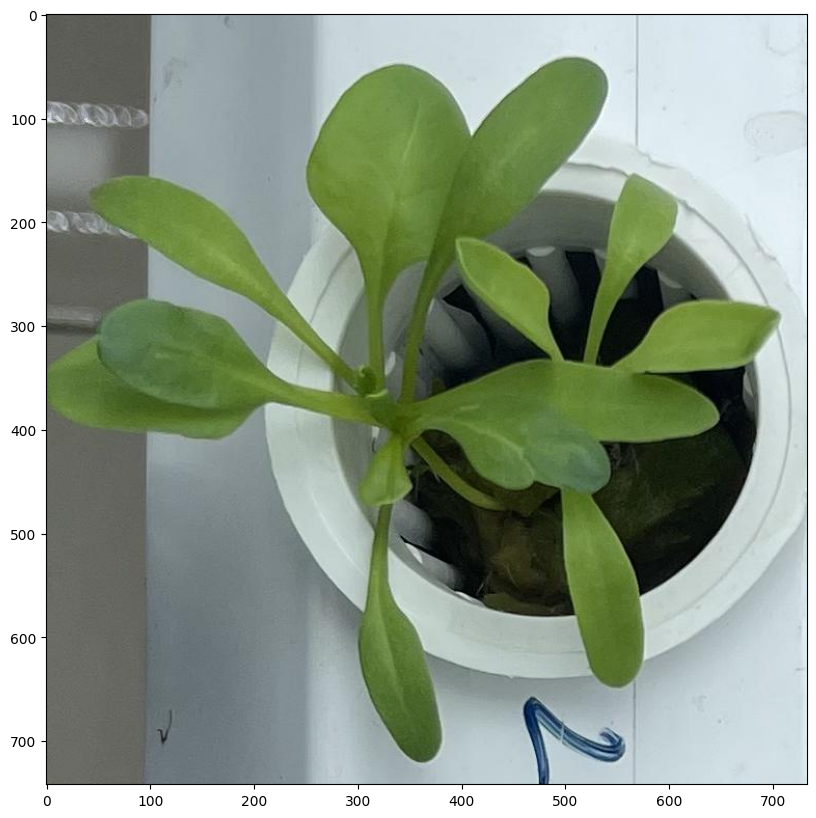

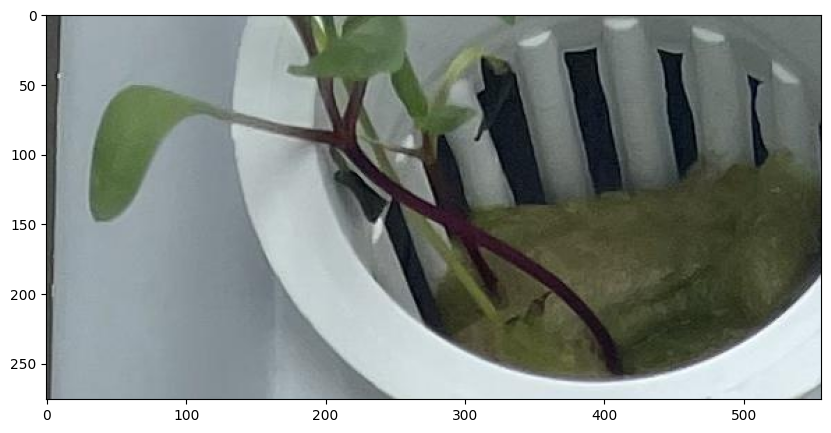

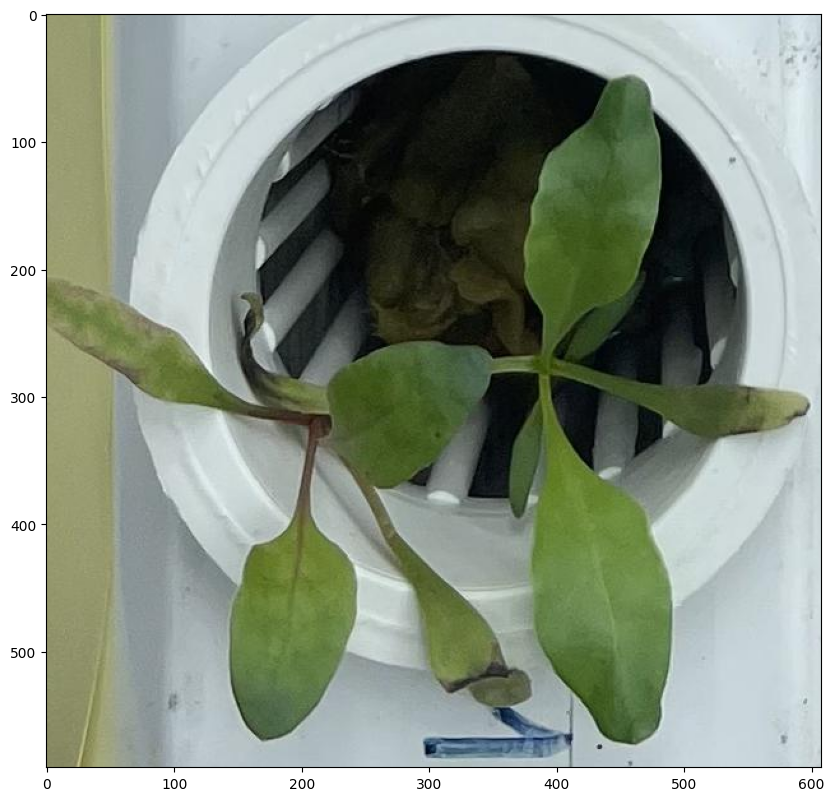

In [ ]:
plt.imshow(crops[0])
plt.show()
plt.imshow(crops[1])
plt.show()
plt.imshow(crops[2])
plt.show()

In [ ]:
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

sam2_checkpoint = "/content/drive/MyDrive/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=device)

predictor = SAM2ImagePredictor(sam2_model)

In [ ]:
greens = []
for i in range(n):
    green = check_green(crops[i])
    greens.append(green)

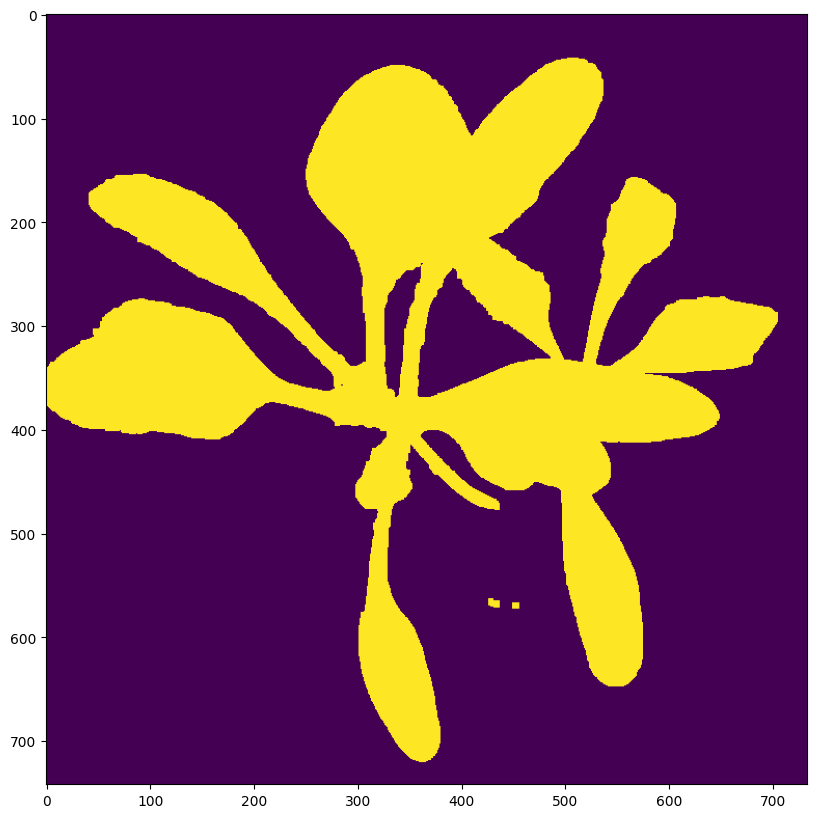

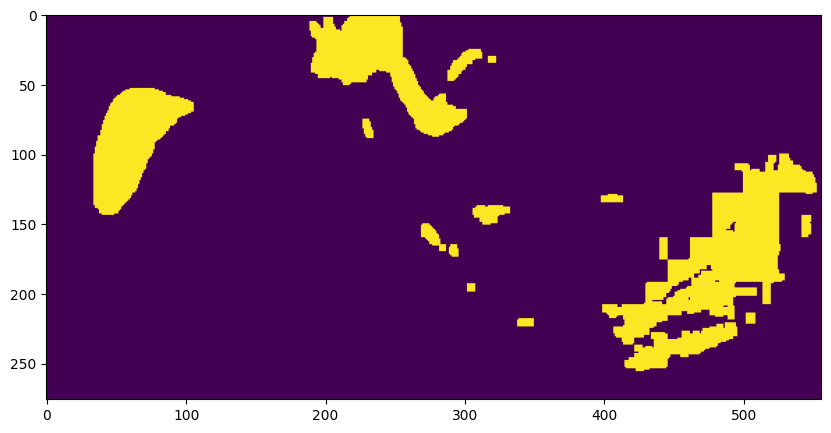

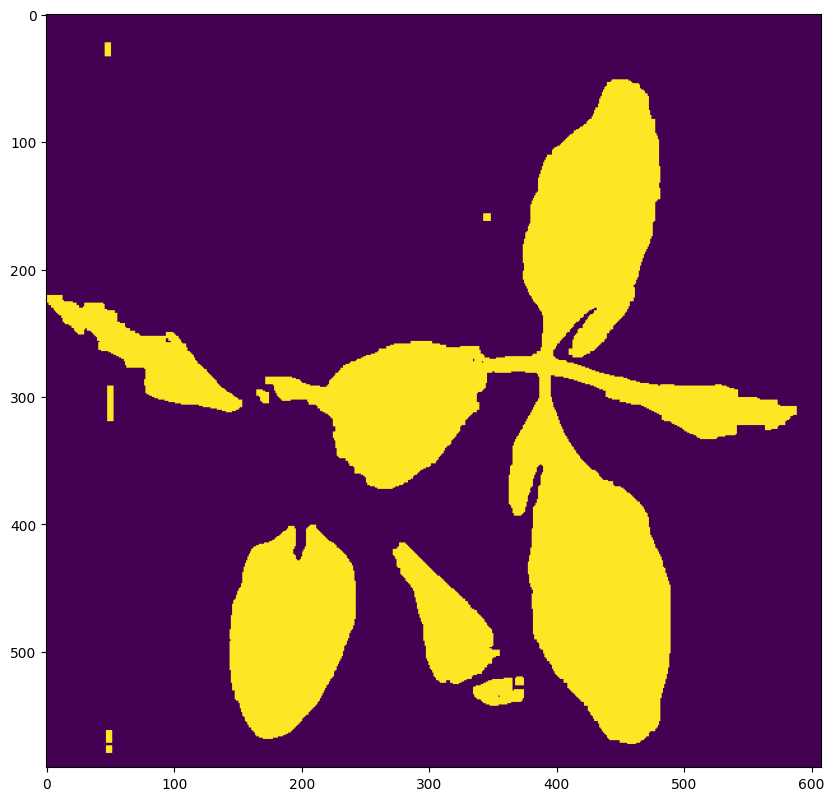

In [ ]:
for i in range(n) :
    plt.imshow(greens[i])
    plt.show()

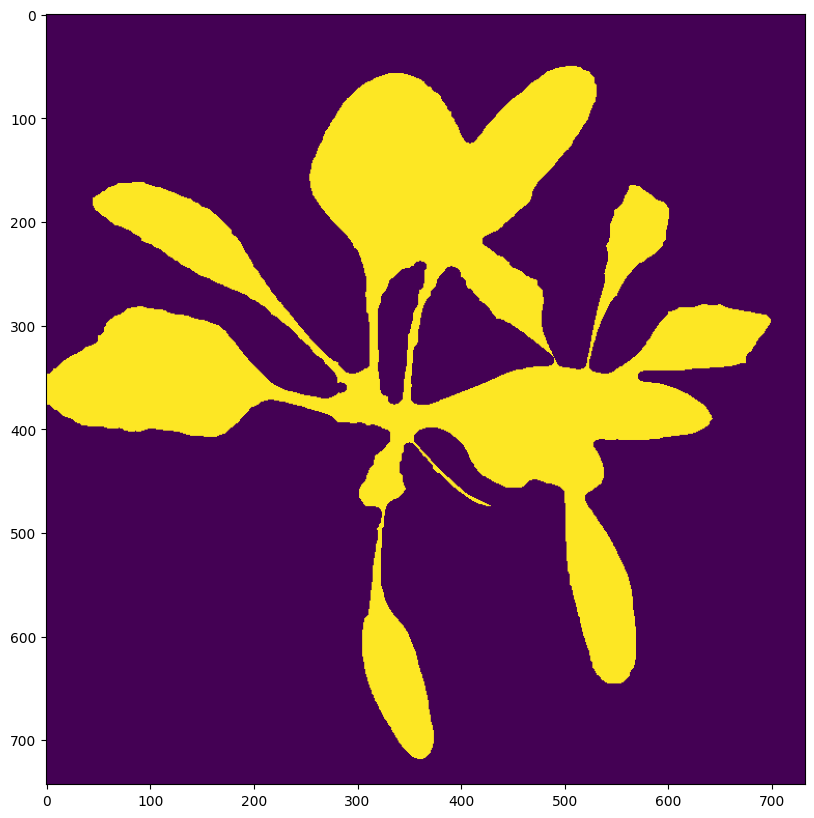

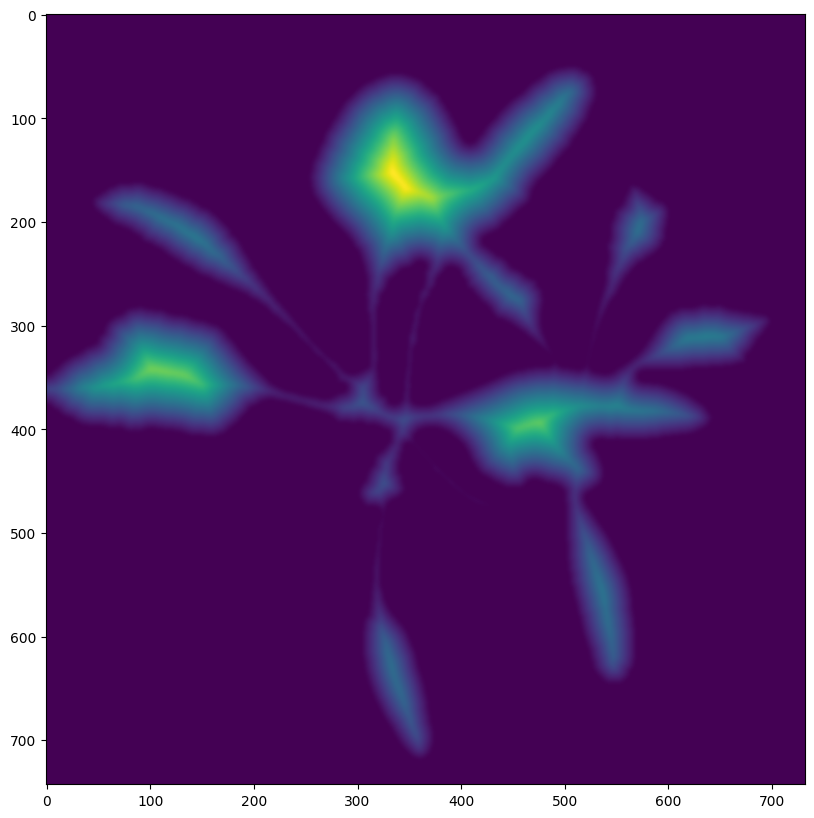

In [ ]:
points = find_leaf_points(greens[0])

In [ ]:
label = np.ones(len(points),dtype = int)
labels = change(label)
points = change(points)

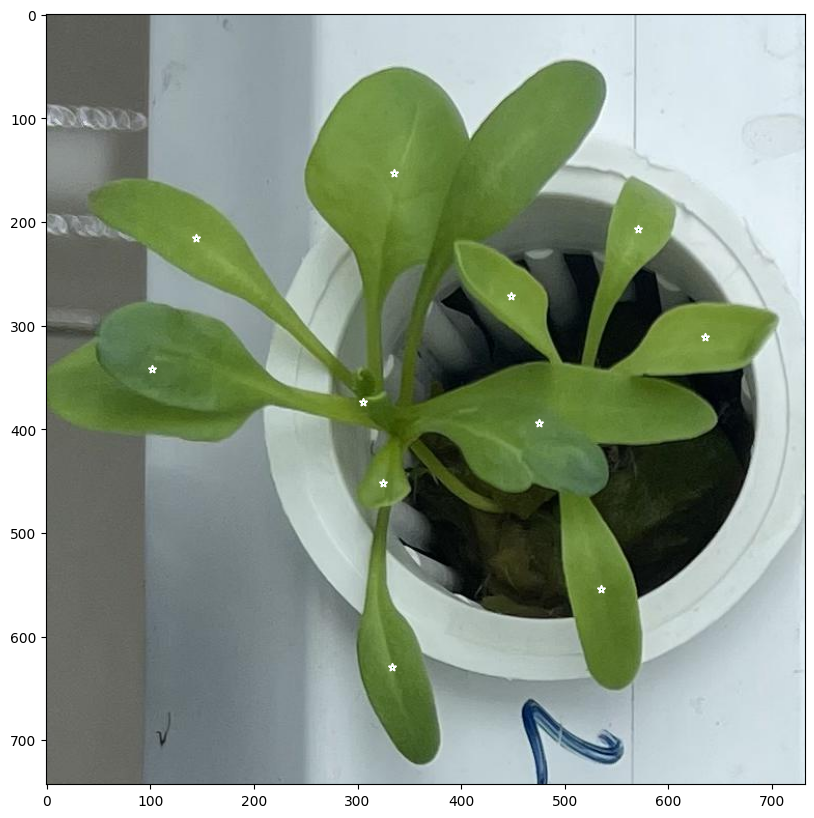

In [ ]:
plt.imshow(crops[0])
show_points(points, labels, plt.gca())
plt.axis('on')
plt.show()

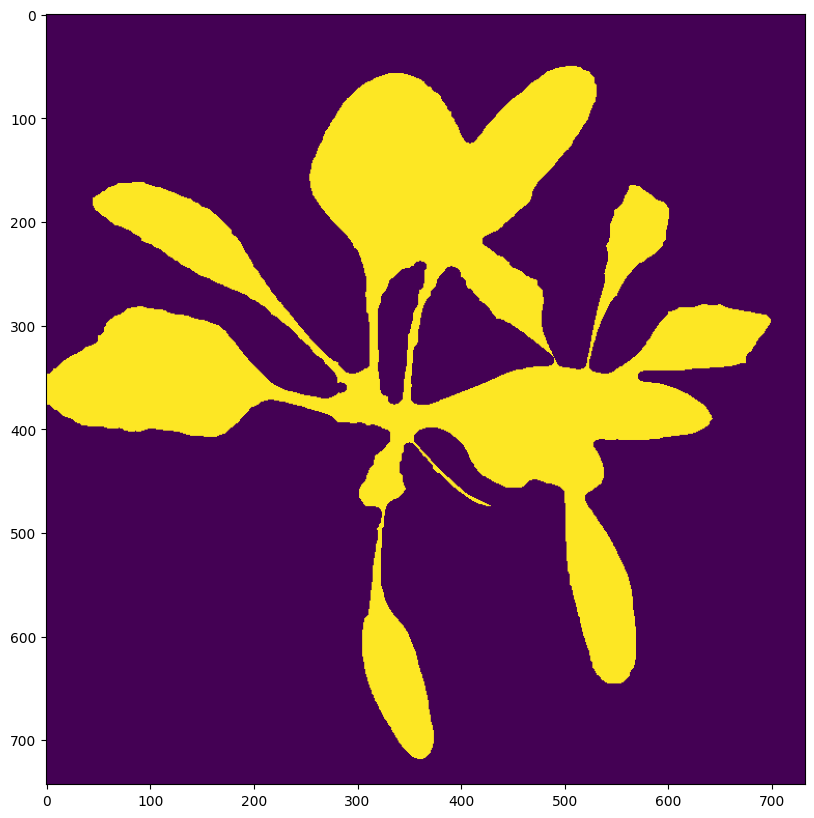

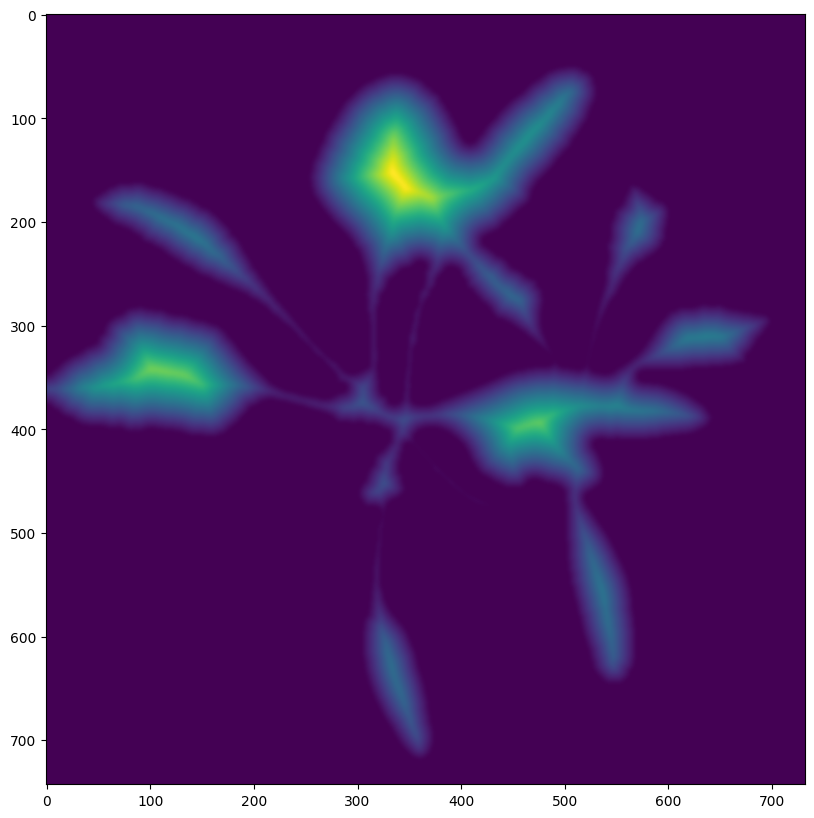

11

In [ ]:
points = find_leaf_points(greens[0])
len(points)

In [ ]:
input_points, input_labels = sam2_inputs(points)

In [ ]:
input_points
input_labels

array([[1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 1],
       [1, 1]])

In [ ]:
predictor.set_image(crops[0])

In [ ]:
masks, scores, _ = predictor.predict(
            point_coords=input_points,
            point_labels=input_labels,
            multimask_output=False,
        )

In [ ]:
image_display = crops[0].copy()

In [ ]:
hc,wc = crops[0].shape[:2]

In [ ]:
mask_f = np.zeros((hc, wc), dtype=np.uint8)
for mask, score in zip(masks, scores):
    if (check_mask(greens[0],mask) == 0) :
        continue
    mask = np.squeeze(mask)
    mask = (mask > 0).astype(np.uint8)
    color = np.random.randint(0, 256, size=(3,), dtype=np.uint8)
    image_display[mask > 0] = color
    mask_f[mask > 0] = 1


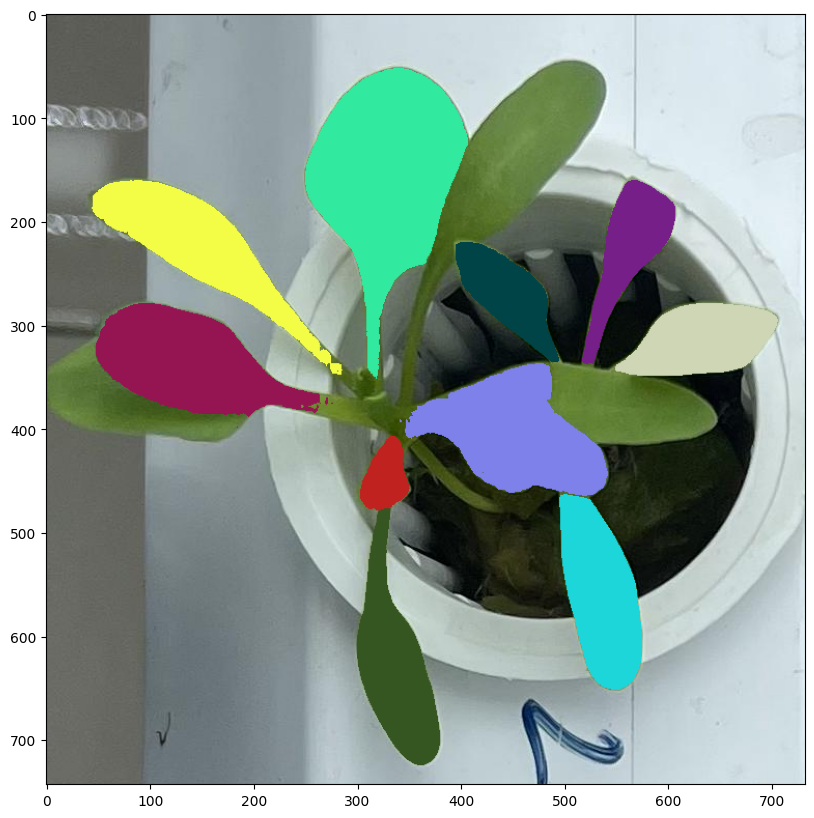

In [ ]:
plt.imshow(image_display)
plt.show()

In [ ]:
greens[0][mask_f > 0] = 0

In [ ]:
green = cv2.morphologyEx(greens[0], cv2.MORPH_OPEN, np.ones((5,5), np.uint8))

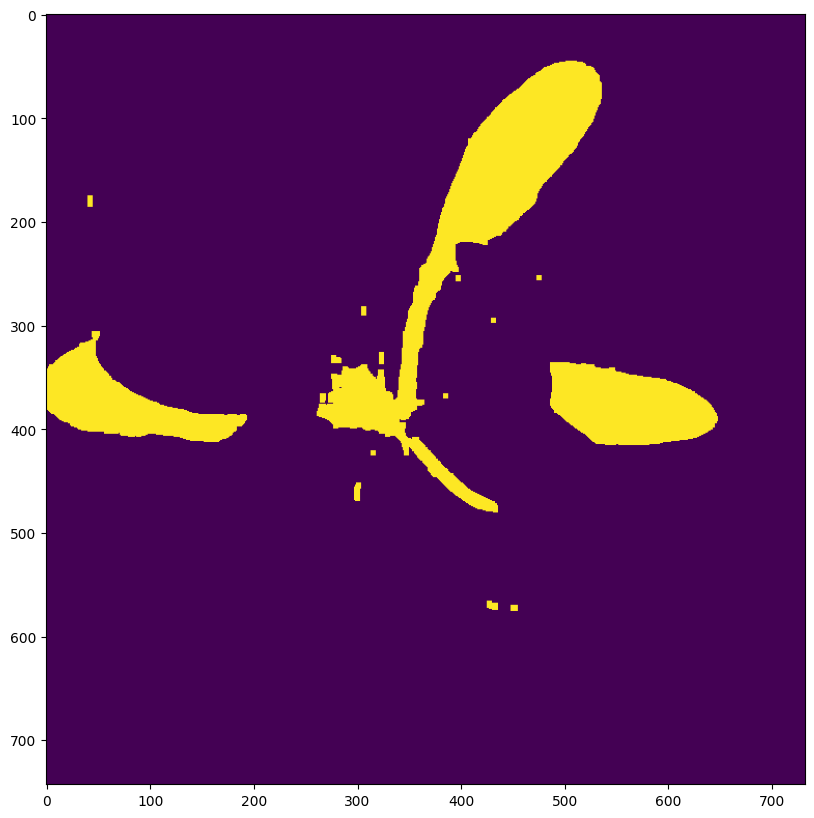

In [ ]:
plt.imshow(green)
plt.show()

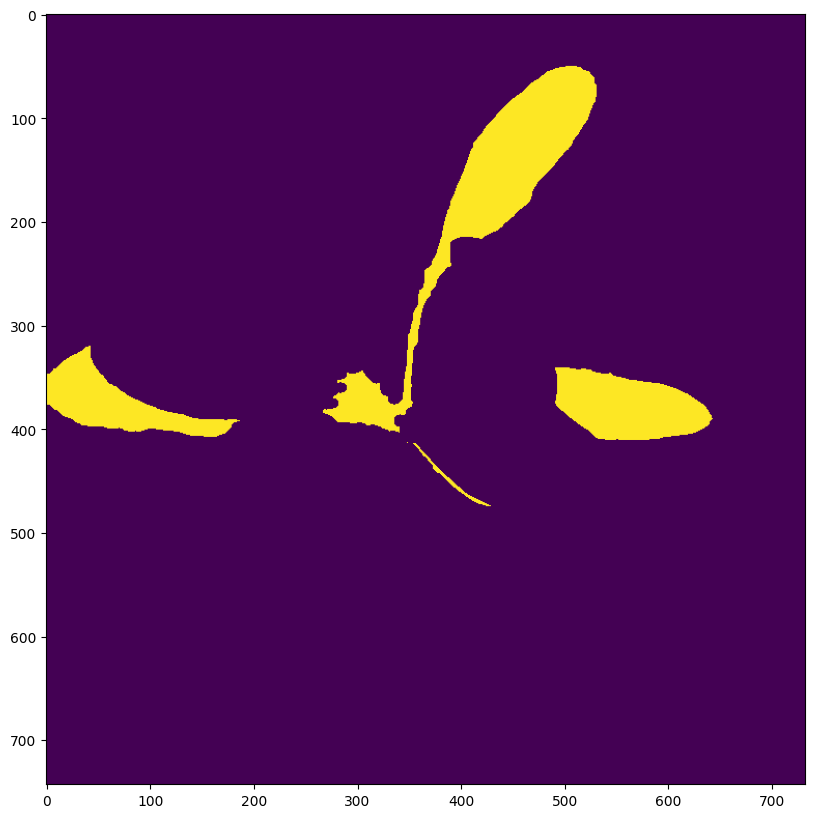

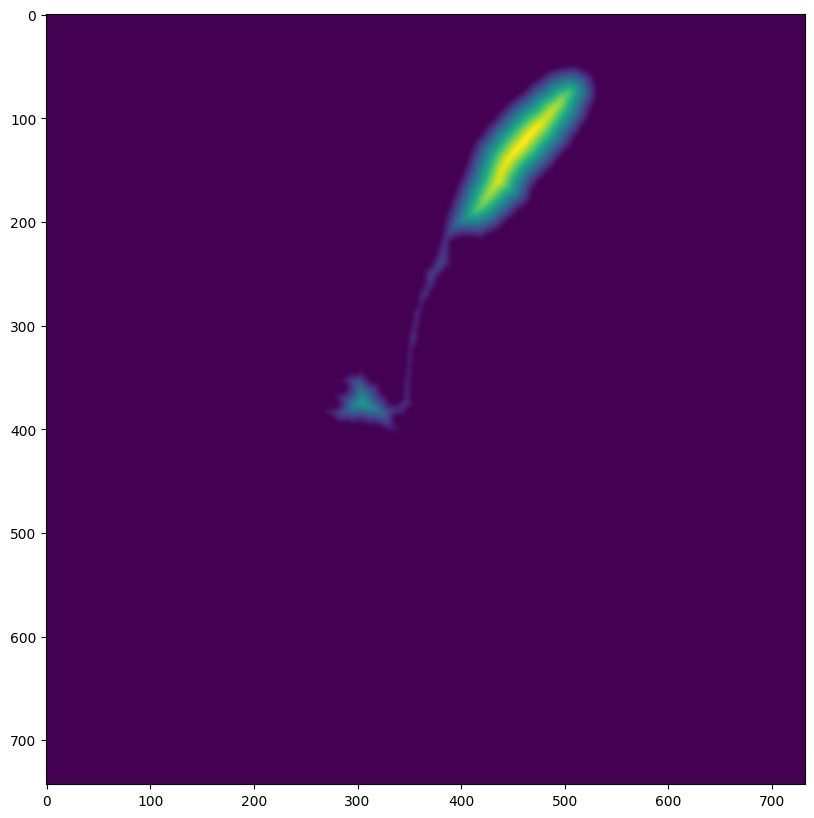

4

In [ ]:
points = find_leaf_points(green)
len(points)

In [ ]:
label = np.ones(len(points),dtype = int)
labels = change(label)
points = change(points)

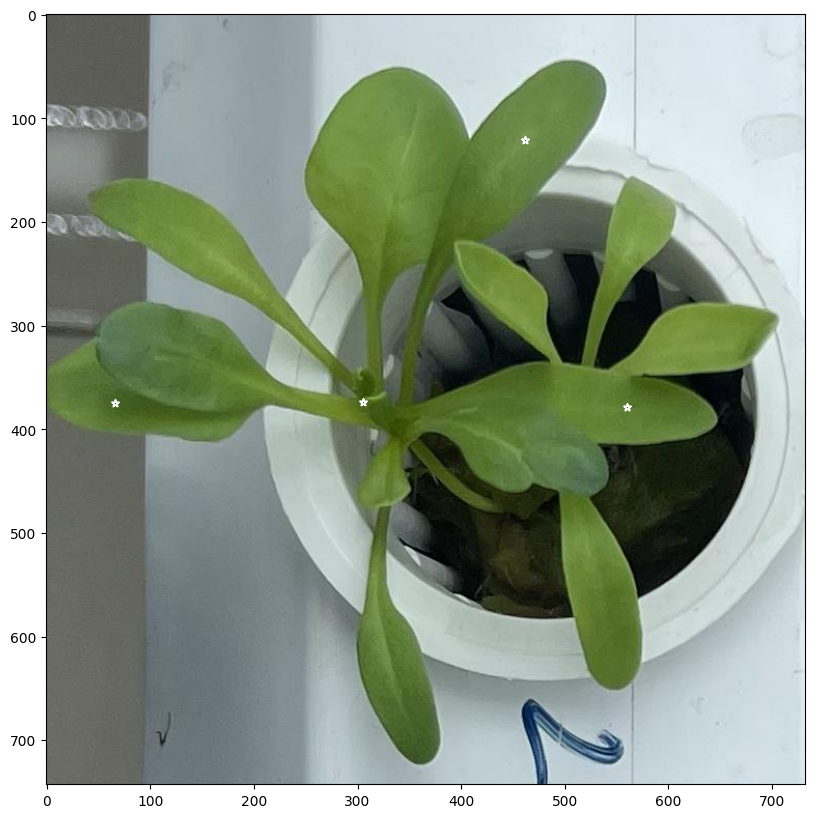

In [ ]:
plt.imshow(crops[0])
show_points(points, labels, plt.gca())
plt.axis('on')
plt.show()

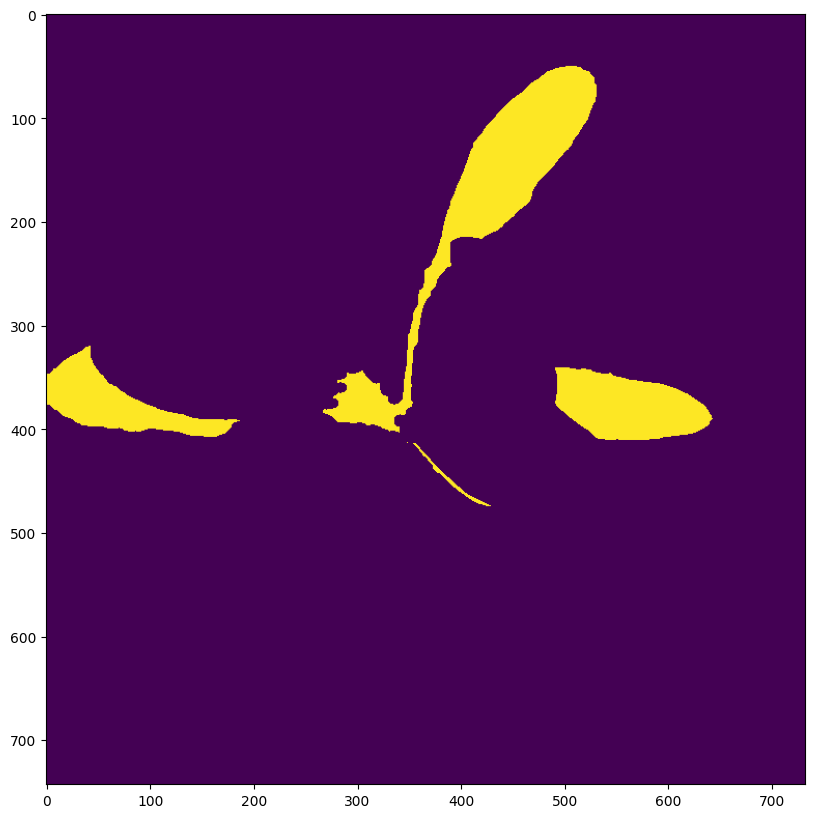

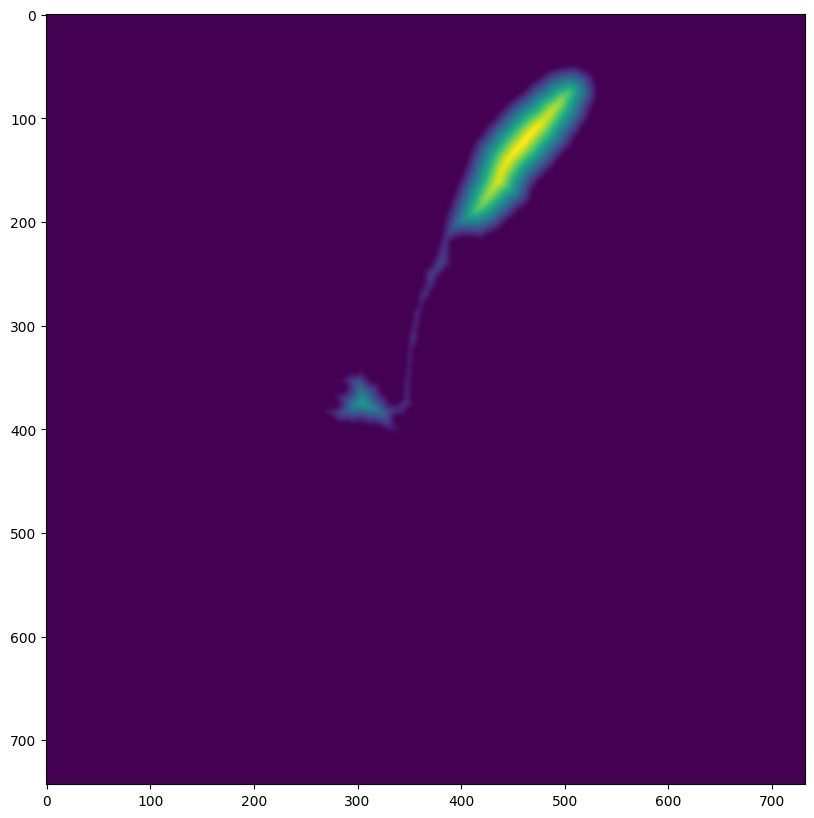

4

In [ ]:
points = find_leaf_points(green)
len(points)

In [ ]:
input_points, input_labels = sam2_inputs(points)

In [ ]:
masks, scores, _ = predictor.predict(
    point_coords=input_points,
    point_labels=input_labels,
    multimask_output=False,
    )

In [ ]:
image_display = crops[0].copy()

In [ ]:
mask_f = np.zeros((hc, wc), dtype=np.uint8)
for mask, score in zip(masks, scores):
    if (check_mask(greens[0],mask) == 0) :
        continue
    mask = np.squeeze(mask)
    mask = (mask > 0).astype(np.uint8)
    color = np.random.randint(0, 256, size=(3,), dtype=np.uint8)
    image_display[mask > 0] = color
    mask_f[mask > 0] = 1


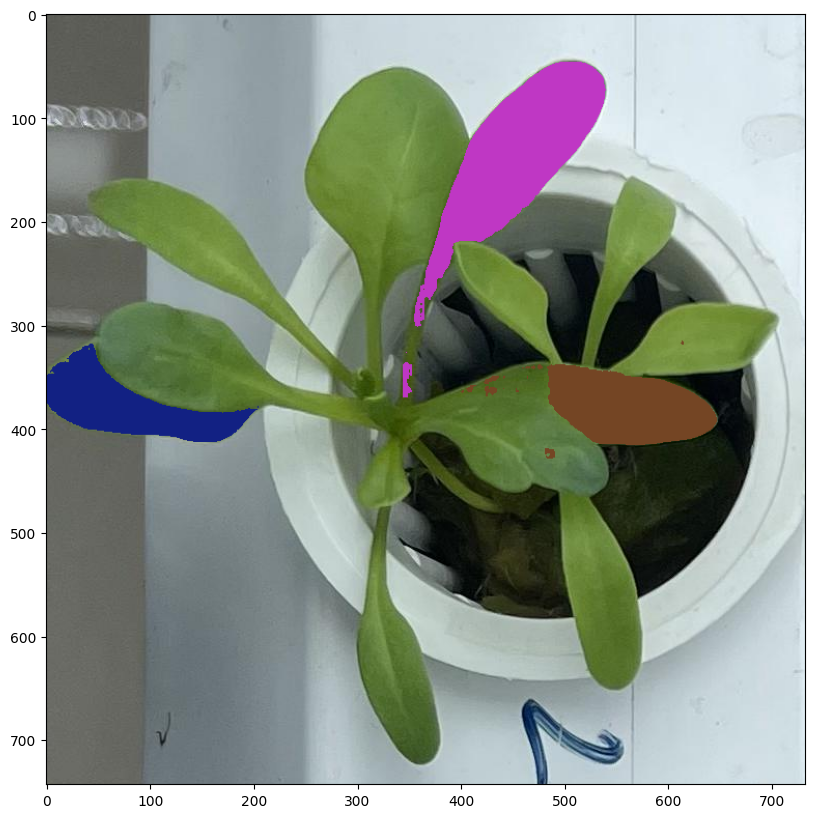

In [ ]:
plt.imshow(image_display)
plt.show()

In [ ]:
h,w = image.shape[:2]

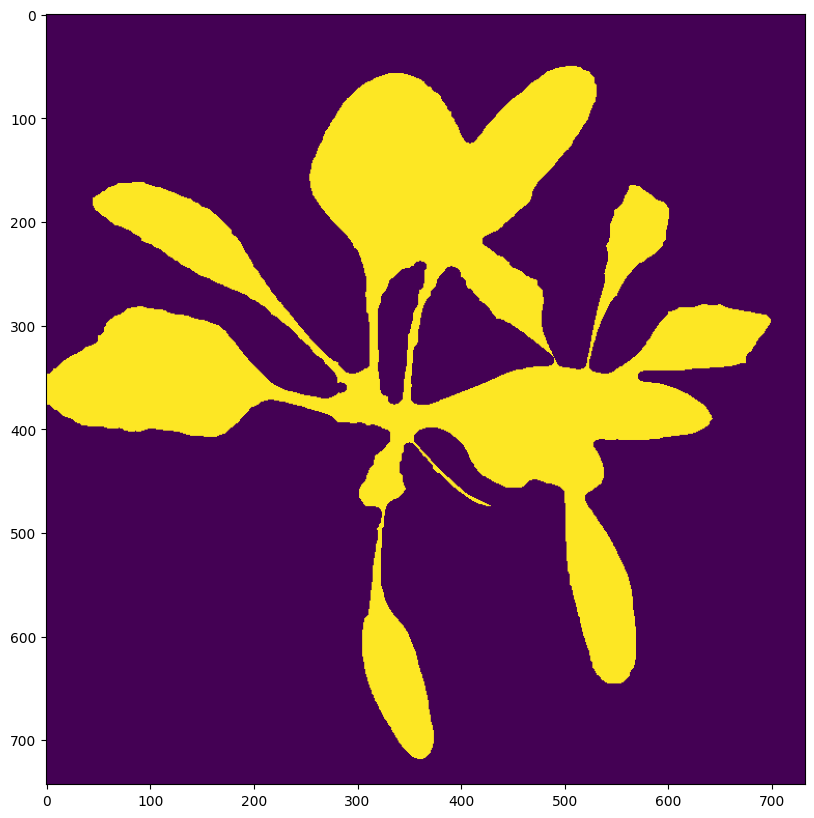

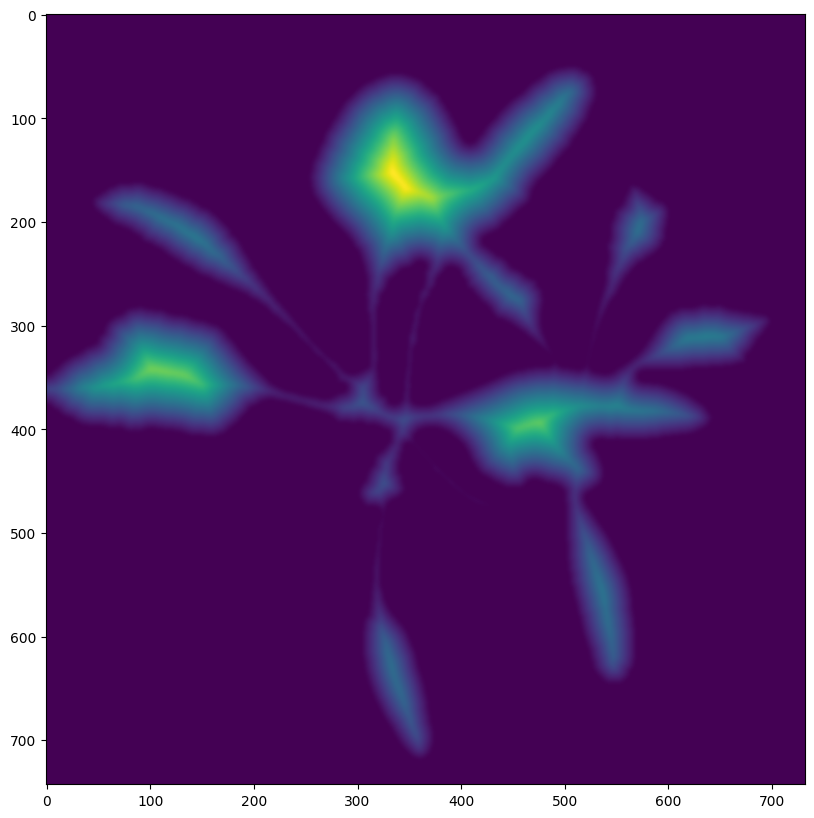

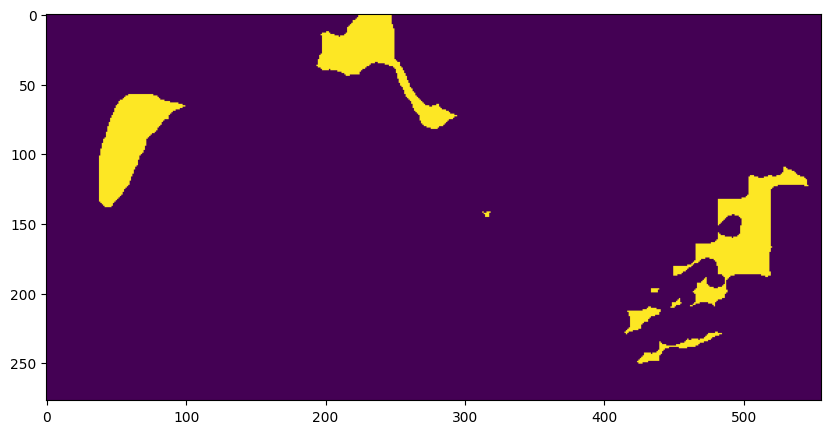

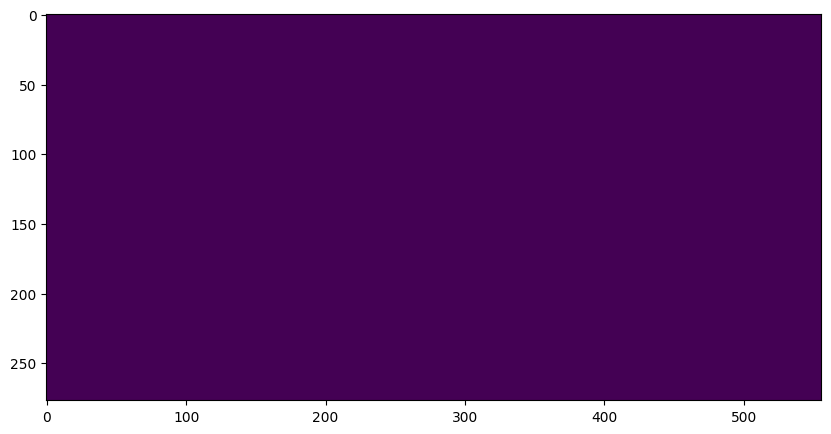

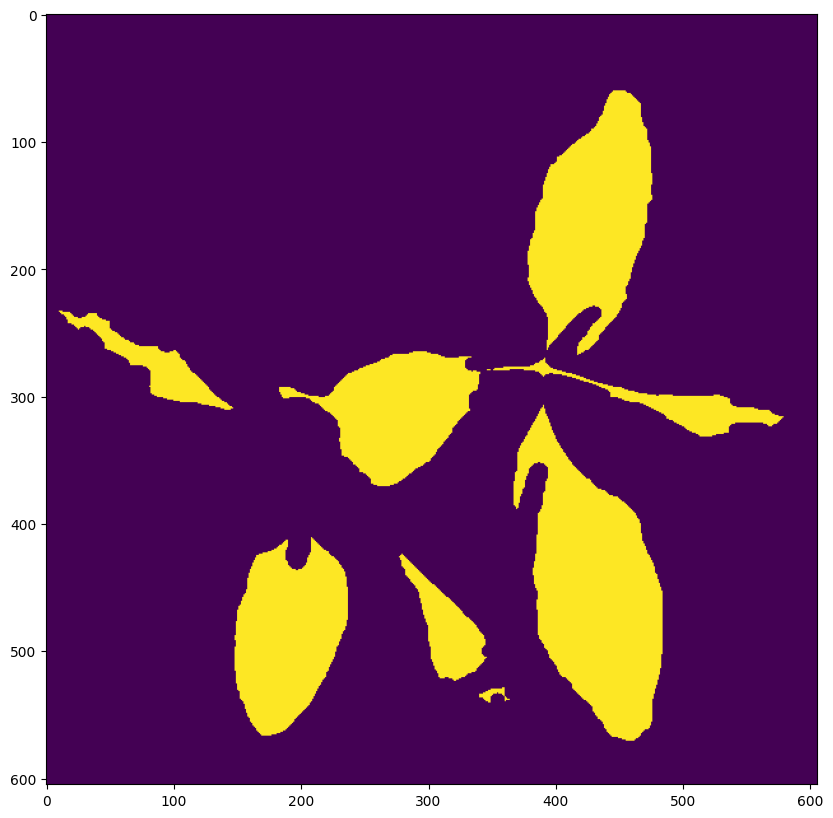

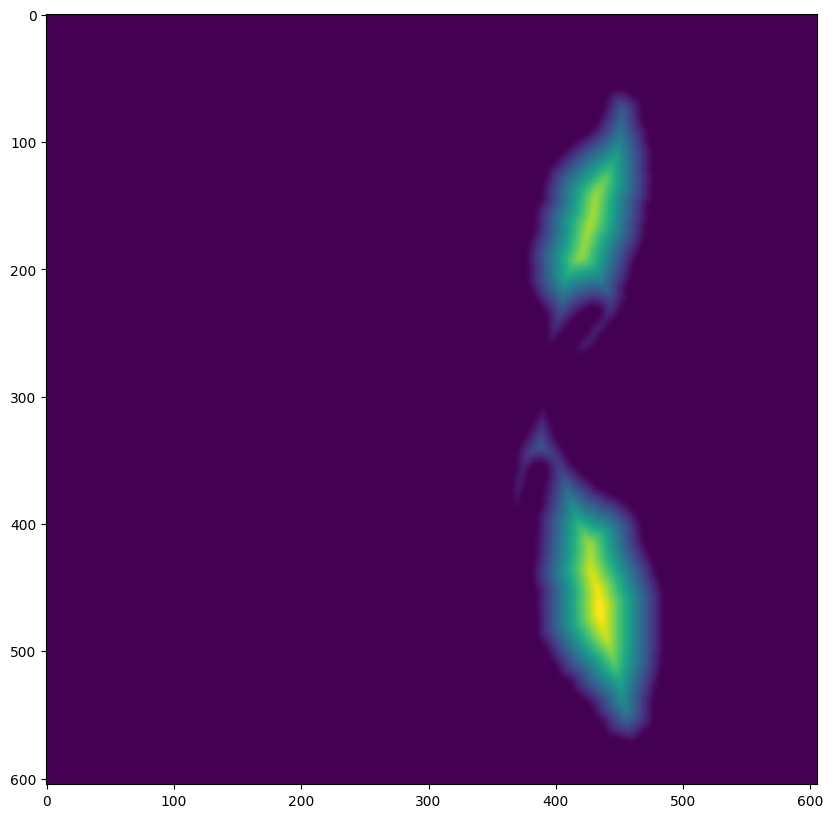

In [ ]:
n = len(crops)
image_display = image_pil.copy()
for i in range(n) :
    green = check_green(crops[i])
    points = find_leaf_points(green)
    input_points,input_labels = sam2_inputs(points)
    with torch.inference_mode(), torch.autocast("cuda", dtype=torch.bfloat16):
      predictor.set_image(crops[i])
      masks, scores, _ = predictor.predict(
          point_coords=input_points,
          point_labels=input_labels,
          multimask_output=False,
      )
      pass
    for mask, score in zip(masks, scores):
        if(check_mask(green,mask) == 0) :
            continue
        mask = mask_full(mask,h,w,positions[i])
        color = np.random.randint(0, 256, size=(3,), dtype=np.uint8)
        image_display[mask > 0] = color

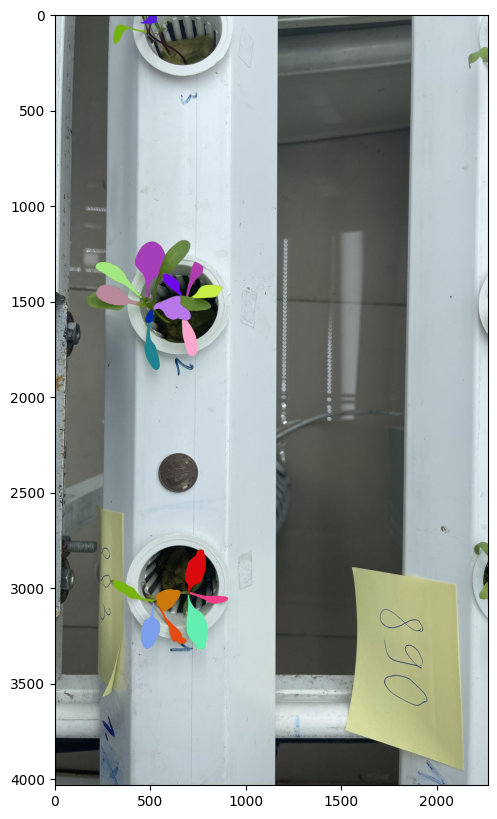

In [ ]:
plt.imshow(image_display)
plt.show()

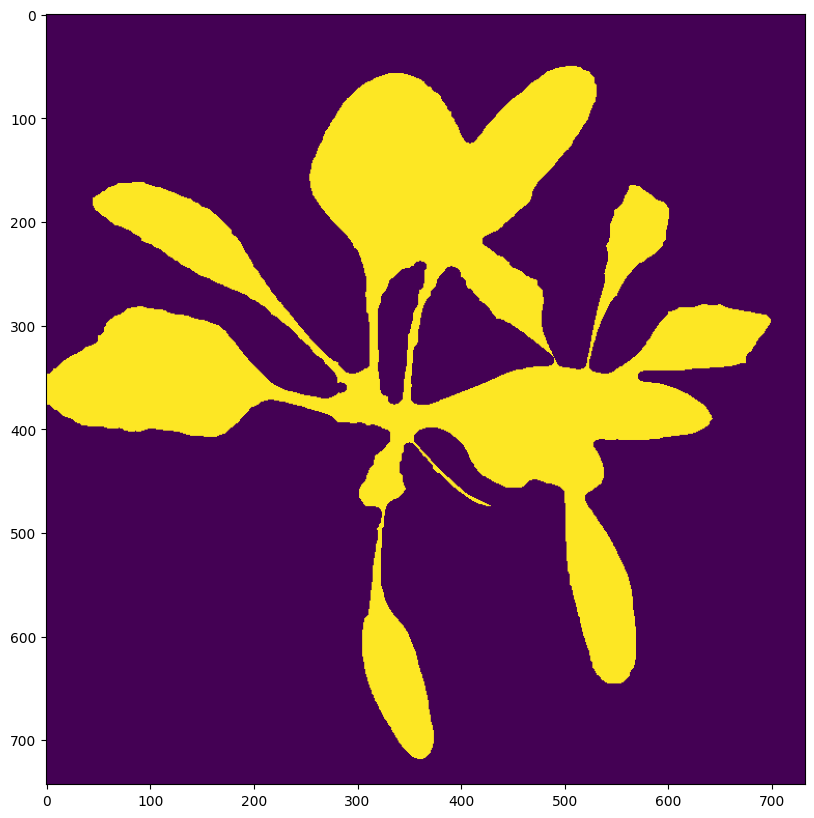

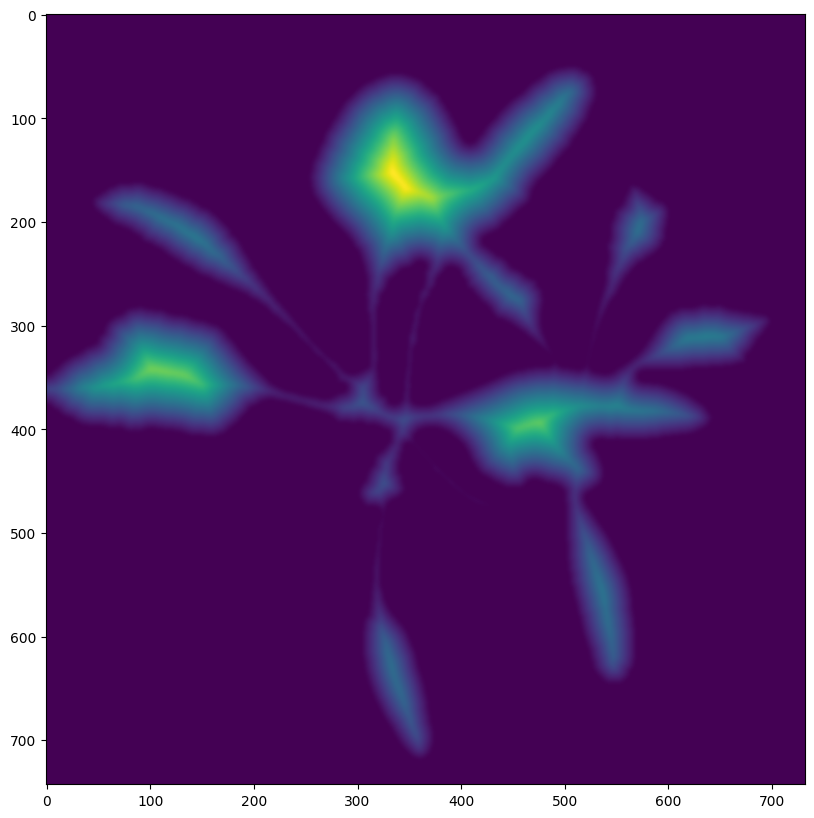

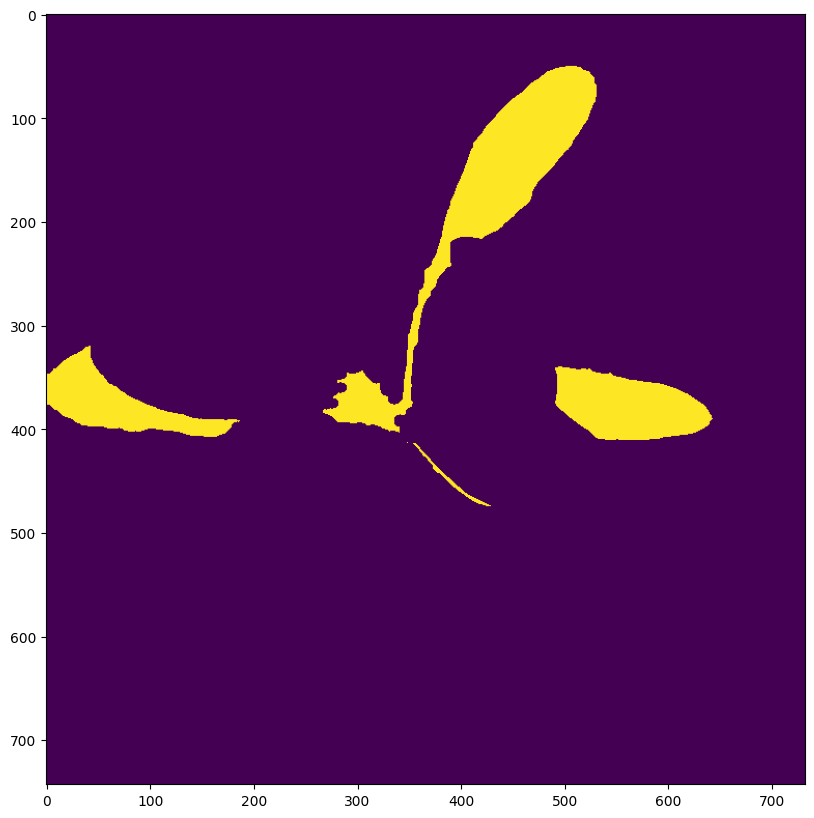

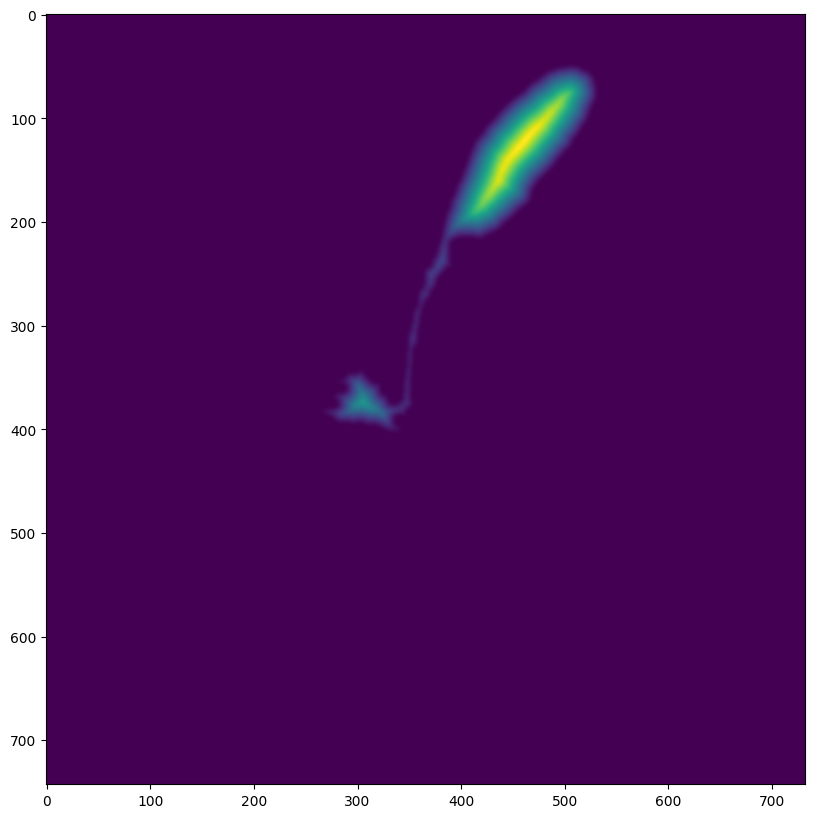

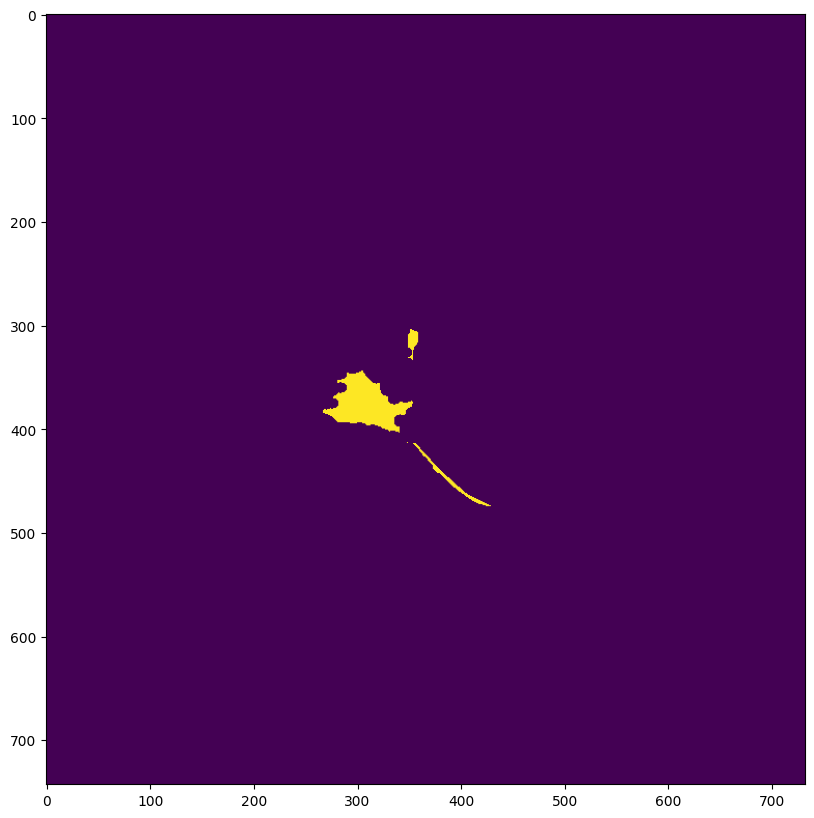

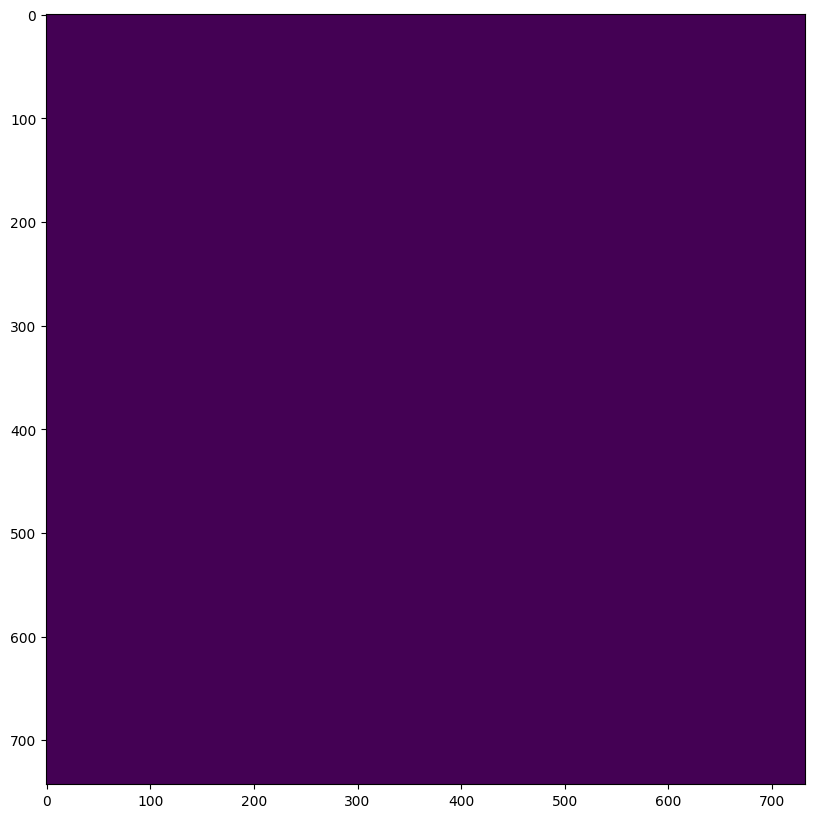

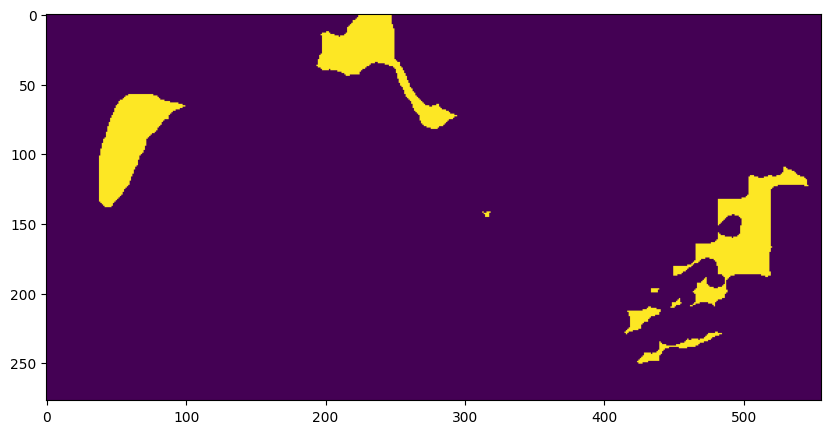

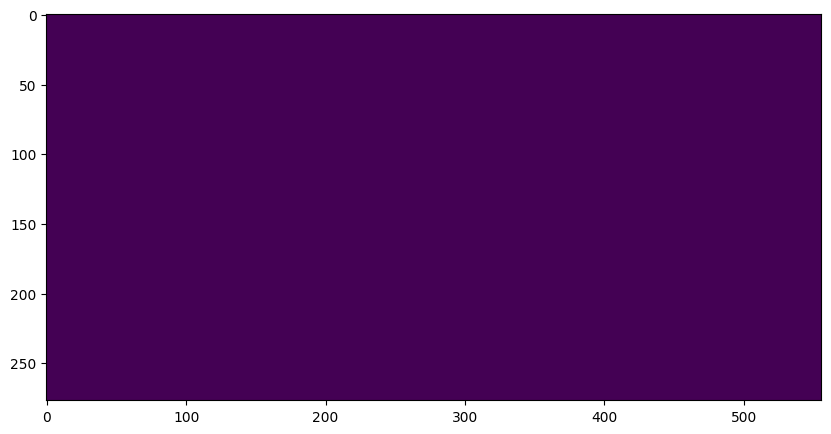

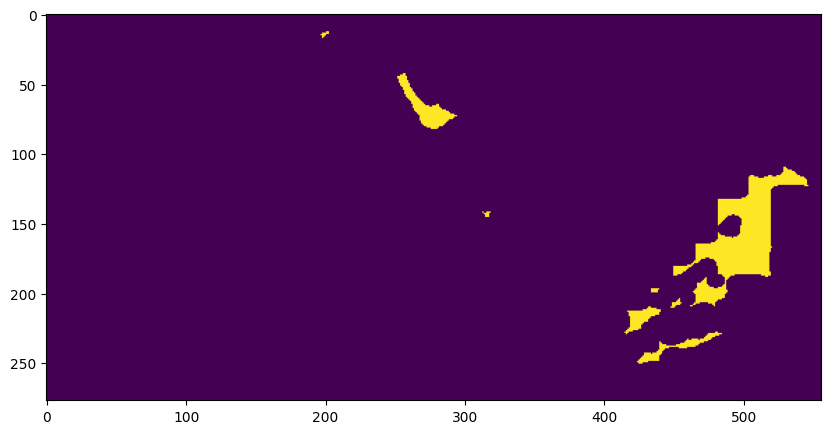

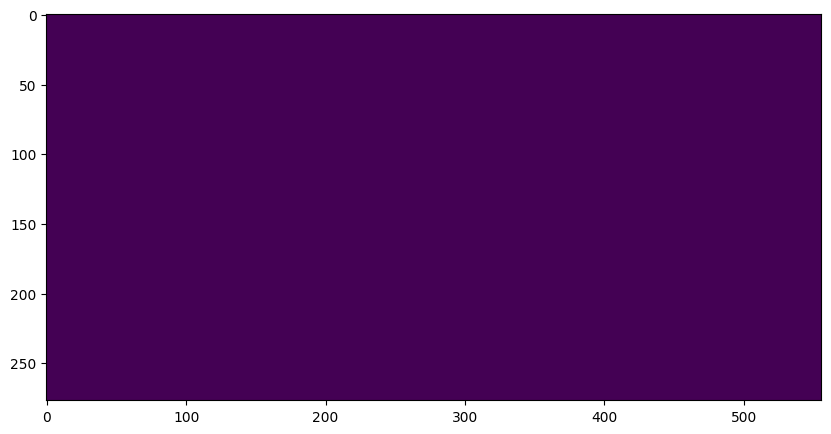

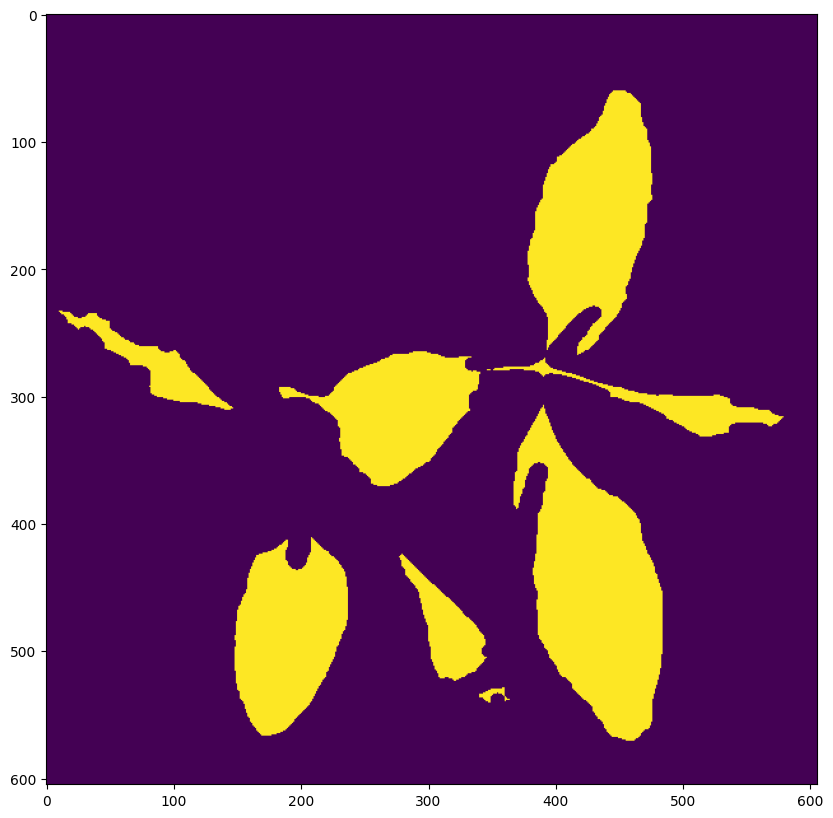

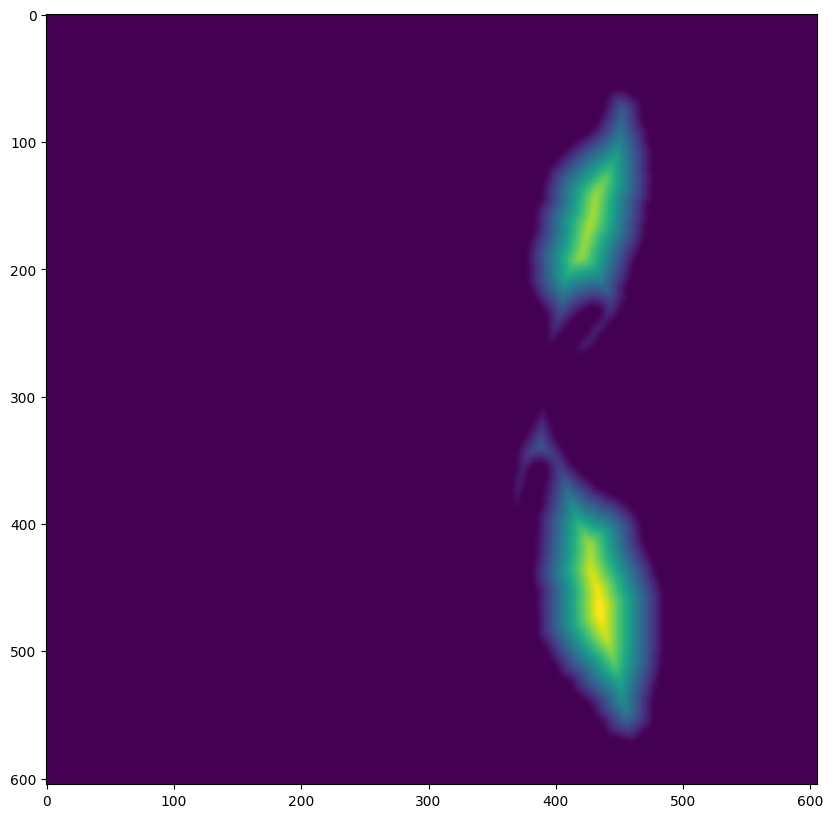

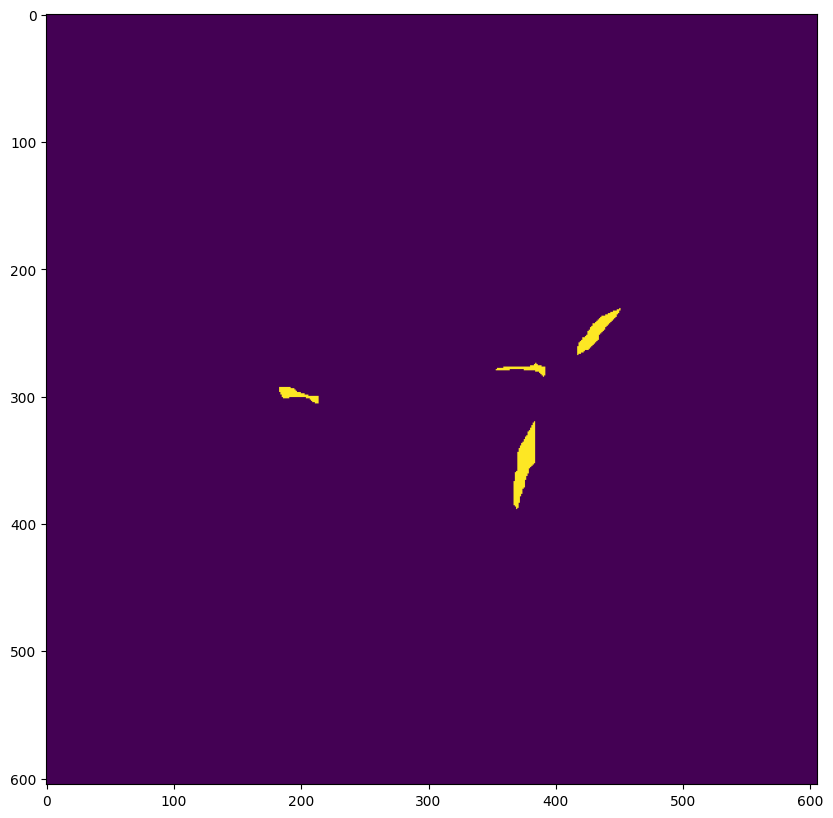

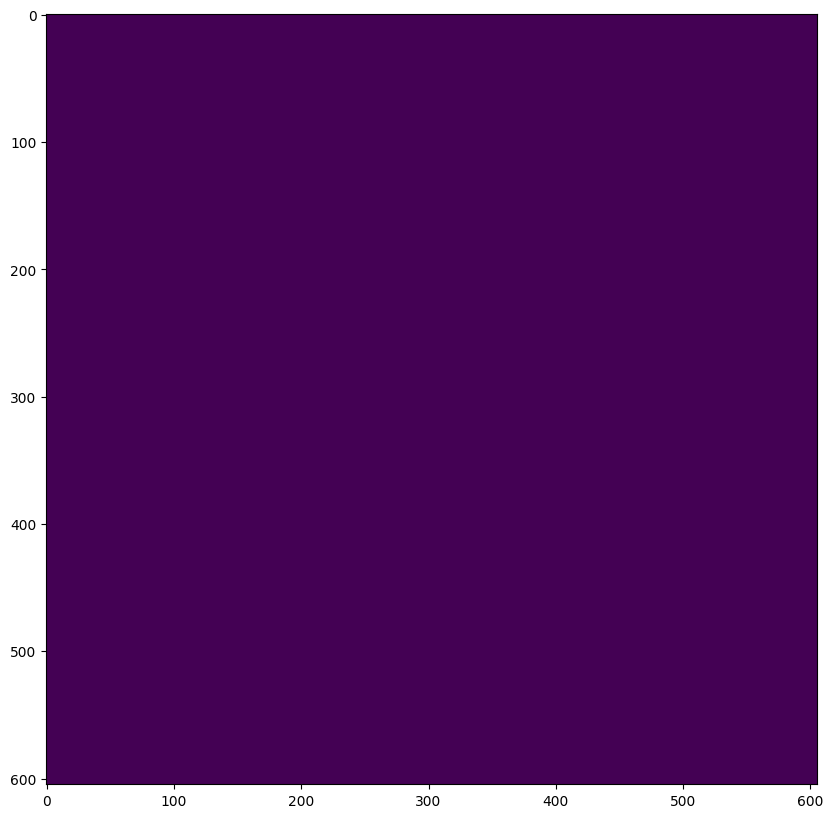

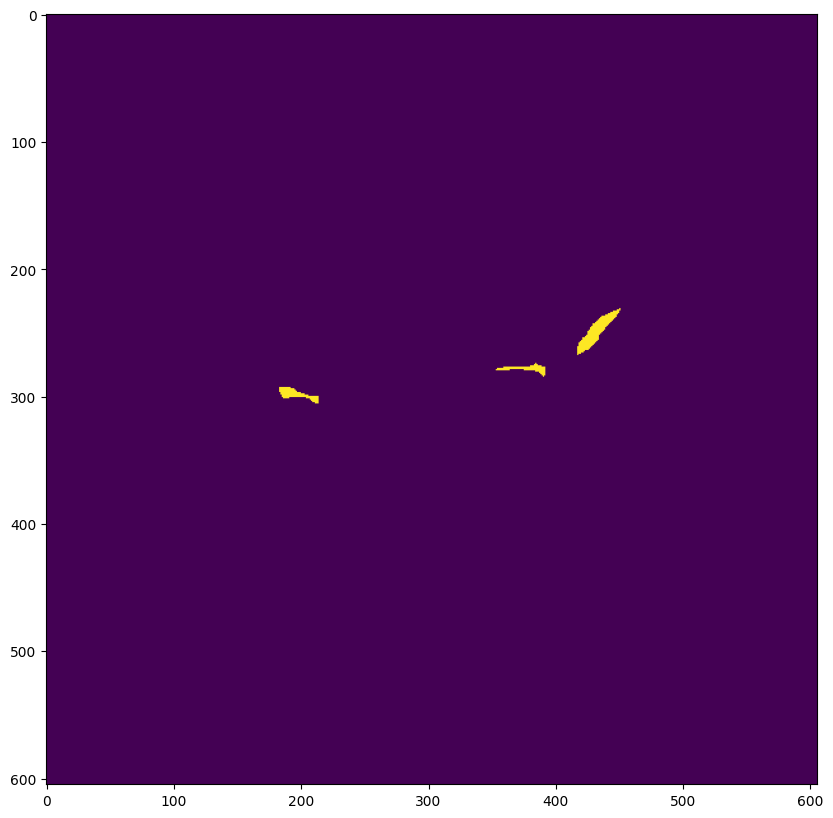

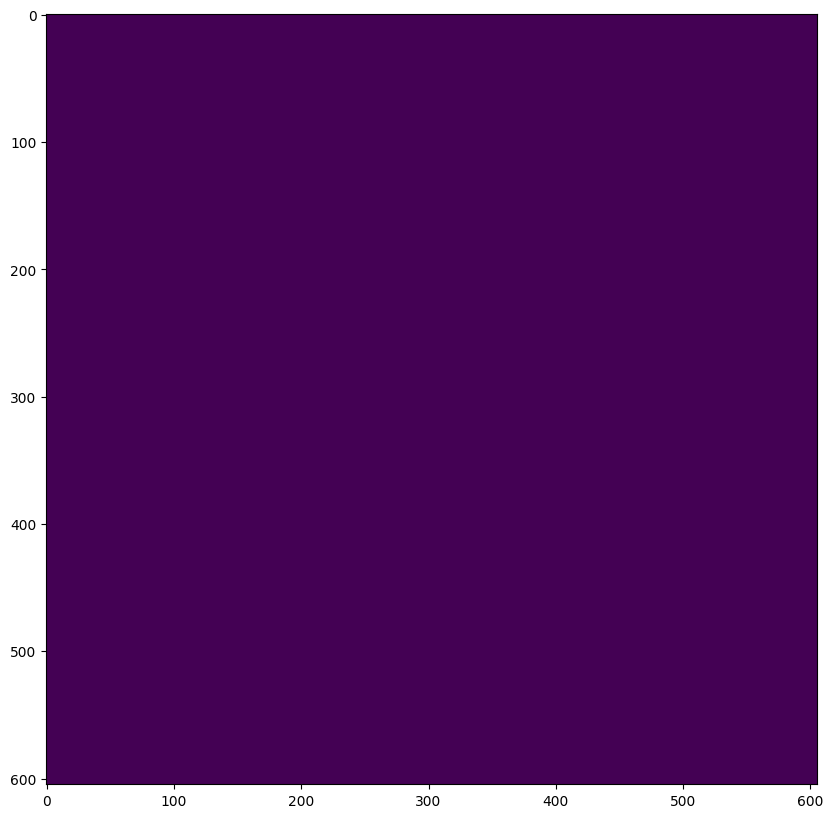

In [ ]:
n = len(crops)
mask_all = []
for i in range(n) :
    image_display = crops[i].copy()
    green = check_green(crops[i])
    predictor.set_image(crops[i])
    crop = crops[i]
    hc,wc = crop.shape[:2]
    for a in range(3) :
        points = find_leaf_points(green)
        if len(points) == 0 : break
        input_points, input_labels = sam2_inputs(points)
        masks, scores, _ = predictor.predict(
            point_coords=input_points,
            point_labels=input_labels,
            multimask_output=False,
        )
        mask_0 = np.zeros((hc, wc), dtype=np.uint8)
        for mask, score in zip(masks, scores):
            if (check_mask(green,mask) == 0) :
                continue
            m = np.squeeze(mask)
            m = (m > 0).astype(np.uint8)
            mask = mask_full(mask,h,w,positions[i])
            mask_0[m > 0] = 1
            mask_all.append(mask)
        if cv2.countNonZero(mask_0) == 0 : break
        green[mask_0 > 0] = 0

In [ ]:
image_display = image_pil.copy()

In [ ]:
for i in mask_all :
    color = np.random.randint(0, 256, size=(3,), dtype=np.uint8)
    image_display[i > 0] = color

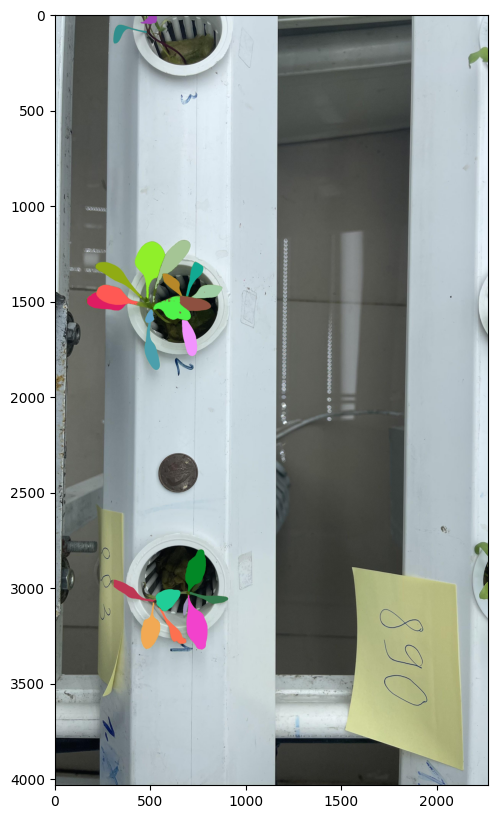

In [ ]:
plt.imshow(image_display)
plt.show()